## 1. Simplified Self-Attention Without Tunable Weights

Self-attention is a mechanism that allows each position in the input sequence to consider the relevancy of, or “attend to,” all other positions in the same sequence when computing the representation of a sequence.

It basically allows the model to relate words to each other.

In self-attention, the “self” refers to the mechanism’s ability to compute attention
 weights by relating different positions within a single input sequence. It assesses and
 learns the relationships and dependencies between various parts of the input itself,
 such as words in a sentence or pixels in an image.

 The “self” part means the attention is within the same input—it looks at the input itself to see how its pieces interact.

Note : Attention score is the unnormalized version of the attention weights.

Attention weights are also called alpha-values.




---

Computing an attention score for a query is done by computing the dot product between the input/query and other sequences.

Dot product can be defined as a measure of how similar two vectors are.


In [ ]:
import torch

In [ ]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
inputs.shape

torch.Size([6, 3])

Right now, let's focus on computing the context vector for the second token.

##Step 1: Compute unnormalized attention scores

In [ ]:
input_query = inputs[1]
print(input_query)

tensor([0.5500, 0.8700, 0.6600])


In [ ]:
attn_scores_2 = torch.empty(inputs.shape[0]) # this initializes a tensor with 6 garbage/ random values
attn_scores_2

tensor([4.2198e-23, 0.0000e+00, 2.0000e+00, 1.8425e+00, 3.6893e+19, 1.7900e+00])

In [ ]:
# for idx, value in enumerate(inputs):
#   print(idx,value)

for i, x_i in enumerate(inputs):
  # print(i,x_i)
  attn_scores_2[i] = torch.dot(x_i, input_query)
  print(f"Attention score for Index {i} = {attn_scores_2[i]}")
  print(f"Attention score  = {attn_scores_2}")


print(f"Final attention scores = {attn_scores_2}")

Attention score for Index 0 = 0.9544000625610352
Attention score  = tensor([9.5440e-01, 0.0000e+00, 2.0000e+00, 1.8425e+00, 3.6893e+19, 1.7900e+00])
Attention score for Index 1 = 1.4950001239776611
Attention score  = tensor([9.5440e-01, 1.4950e+00, 2.0000e+00, 1.8425e+00, 3.6893e+19, 1.7900e+00])
Attention score for Index 2 = 1.4754000902175903
Attention score  = tensor([9.5440e-01, 1.4950e+00, 1.4754e+00, 1.8425e+00, 3.6893e+19, 1.7900e+00])
Attention score for Index 3 = 0.8434000015258789
Attention score  = tensor([9.5440e-01, 1.4950e+00, 1.4754e+00, 8.4340e-01, 3.6893e+19, 1.7900e+00])
Attention score for Index 4 = 0.7070000171661377
Attention score  = tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.7900])
Attention score for Index 5 = 1.0865000486373901
Attention score  = tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Final attention scores = tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


##Step 2: Normalize the unnormalized attention scores ("omegas", ) so that they sum up to 1

In [ ]:
# Doing it manually first

attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.

In [ ]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0) # this is just the softmax formula

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [ ]:
# There is also a direct way to do in PyTorch

attn_weights = torch.softmax(attn_scores_2, dim=0)
print(f"Attention weights : {attn_weights}")
print(f"Sum over the weights : {attn_weights.sum()}")

Attention weights : tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum over the weights : 1.0


##Step 3: Compute the context vector by multiplying the embedded input tokens, with the attention weights and sum the resulting vectors:


```
context_vec =
0.1385*[0.43,0.15,0.89] +
0.2379*[0.55,0.87,0.66] +
0.2333*[0.57,0.85,0.64] +
0.1240*[0.22,0.58,0.33] +
0.1082*[0.77,0.25,0.10] +
0.1581*[0.05,0.80,0.55]
```

1. Multiply the score with the first value across all rows.


```
0.1385*0.43 + 0.2379*0.55 + 0.2333*0.57 + 0.1240*0.22 + 0.1082*0.77 + 0.1581*0.05
≈ 0.4419
```
2. Repeat over all.

3. Final Context Vector

```
tensor([0.4419, 0.6515, 0.5683])
```

In [ ]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


##Computing Attention Weights for all input tokens

Above, we computed the attention weights and context vector for input 2.

In [ ]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])



###Visual Representation of what @ does ( Look at notes for more ref )
```
A =         A.T =      Result = A @ A.T  # Mutiplies Row Of A to cols of A.T
[1 2 3]    [1 4]       [1*1+2*2+3*3 , 1*4+2*5+3*6]   => [14,32]
[4 5 6]    [2 5]       [4*1+5*2+6*3 , 4*4+5*5+6*6]   => [32,77]
           [3 6]

```



In [ ]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [ ]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [ ]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


##2. Implementing Self-Attention with Tunable Weights

In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs.


**This self-attention mechanism is also called "scaled dot-product attention".**


We will be introducing trainable weights here but the goal is still to compute the context vectors.

Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices :

1. Key
2. Query
3. Value




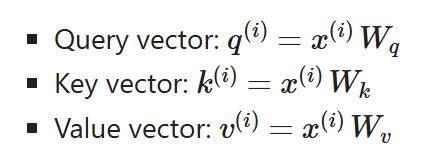


In [ ]:
x_2 = inputs[1]
d_in = x_2.shape # Basically, this is supposed to be d_model. Simply said, the total numbers used to embed one token (3 in this case).
d_out = 2 # We can choose this ourselves.
x_2,d_in # The output embedding size, d=2

(tensor([0.5500, 0.8700, 0.6600]), torch.Size([3]))

In [ ]:
# Initializing the Query, Key and Value Matrices

torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(*d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(*d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(*d_in, d_out), requires_grad=False)

###Now, we can compute q1, k1 and v1.

These are for the token 2 only that we have defined as x_2.



```
Token 2 wants to "ask" the sentence:
   "Which tokens are important to me?"

- It sends its query Q_2 to all keys (K_1, K_2, K_3...) → calculate scores
- Scores → softmax → attention weights
- Multiply weights with value vectors (V_1, V_2, V_3...) → sum → context_2

```



In [ ]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
query_2

tensor([0.4306, 1.4551])

In [ ]:
key_2

tensor([0.4433, 1.1419])

In [ ]:
# Generating Keys and Values for all tokens since they will be unique

keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)
keys

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])

Previously, we computed the attention by using the query and the inputs but this time we will not be working with the inputs directly.

In [ ]:
query_2

tensor([0.4306, 1.4551])

In [ ]:
att_scr_2 = query_2.dot(key_2)
att_scr_2

tensor(1.8524)

In [ ]:
keys.T

tensor([[0.3669, 0.4433, 0.4361, 0.2408, 0.1827, 0.3275],
        [0.7646, 1.1419, 1.1156, 0.6706, 0.3292, 0.9642]])

In [ ]:
# But we have to calculate the attention scores betweent the query and all input's keys.
# We cannot use .dot () here because it only works with 1D tensors of same shape.
# dot() can’t handle 1D × 2D.

attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [ ]:
# Alternatively, we can write it as :

attn_scores_2 = torch.matmul(query_2, keys.T)
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


 Now, we want to go from the attention scores to the attention weights. We compute the attention weights by scaling the attention scores and using the softmax function.

 However, now we scale the attention scores by dividing
 them by the square root of the embedding dimension of the keys (taking the squareroot is mathematically the same as exponentiating by 0.5):

In [ ]:
d_k = keys.shape[1]
print(d_k)
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

2
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [ ]:
values

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])

###Calculating the context vector for query 2



```
attn_weights_2 ≈ [0.128, 0.190, 0.186, 0.106, 0.072, 0.319]
values = [[v1_x, v1_y],
          [v2_x, v2_y],
          [v3_x, v3_y],
          [v4_x, v4_y],
          [v5_x, v5_y],
          [v6_x, v6_y]]
```


```
context_vec_2[0] = 0.128*v1_x + 0.190*v2_x + ... + 0.319*v6_x
context_vec_2[1] = 0.128*v1_y + 0.190*v2_y + ... + 0.319*v6_y
```





In [ ]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## Implementing a compact Self-Attention class

Let's compute the context vector for all inputs.

In [ ]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(*d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(*d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(*d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [ ]:
# By using LinearLayer

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Linear(*d_in, d_out, bias=False)
        self.W_key   = nn.Linear(*d_in, d_out, bias=False)
        self.W_value = nn.Linear(*d_in, d_out, bias=False)

    def forward(self, x):
        keys = self.W_key(x) # pytorch performs a linear transformation now : keys = x @ W_KEY.T + b, similar for queries and values too
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


##3. Hiding future words with causal attention

In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight.

<image src = "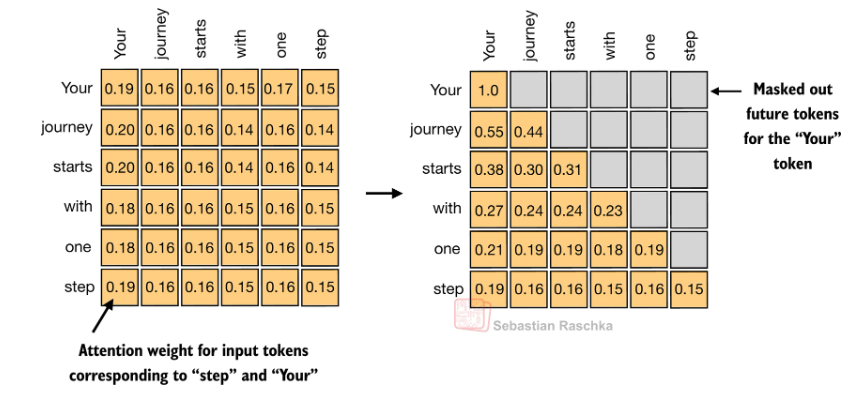" width  = 50%>

More examples in working with text data file.

In [ ]:
queries = inputs @ W_query   # shape: (6, d_out)
keys    = inputs @ W_key
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799],
        [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
        [0.1503, 0.2256, 0.2192, 0.1315, 0.0914, 0.1819],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.1206, 0.1769],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.1752],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


In [ ]:
attn_weights.shape

torch.Size([6, 6])

In [ ]:
context_length = inputs.shape[0] # this is the total number of tokens
print(f"Total number of words : {context_length}")
mask_simple = (torch.ones(context_length, context_length))
print(f"Without Masking :\n {mask_simple}")
mask_simple = torch.tril(mask_simple) # torch.tril automatically builds a mask that prevents a token from looking ahead.
# it makes sure we have ones below the diagonal and zeros above the diagonal.
print(f"After Masking :\n {mask_simple}")

Total number of words : 6
Without Masking :
 tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
After Masking :
 tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [ ]:
masked_simple = attn_weights*mask_simple
print(masked_simple) # this is our attention score table

tensor([[0.1551, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1500, 0.2264, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1503, 0.2256, 0.2192, 0.0000, 0.0000, 0.0000],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.0000, 0.0000],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.0000],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


In [ ]:
masked_simple.shape

torch.Size([6, 6])

But, if we look at the table, we notice that the values in the table don't sum up to one anymore. So, we need to renormalize it.

In [ ]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3986, 0.6014, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2526, 0.3791, 0.3683, 0.0000, 0.0000, 0.0000],
        [0.2265, 0.2839, 0.2794, 0.2103, 0.0000, 0.0000],
        [0.1952, 0.2363, 0.2331, 0.1820, 0.1534, 0.0000],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


## Information leakage
 When we apply a mask and then renormalize the attention weights, it might initially
 appear that information from future tokens (which we intend to mask) could still influ
ence the current token because their values are part of the softmax calculation. How
ever, the key insight is that when we renormalize the attention weights after masking,
 what we’re essentially doing is recalculating the softmax over a smaller subset (since
 masked positions don’t contribute to the softmax value).


 The mathematical elegance of softmax is that despite initially including all positions
 in the denominator, after masking and renormalizing, the effect of the masked posi
tions is nullified—they don’t contribute to the softmax score in any meaningful way.


 In simpler terms, after masking and renormalization, the distribution of attention
 weights is as if it was calculated only among the unmasked positions to begin with.
 This ensures there’s no information leakage from future (or otherwise masked)
 tokens as we intended

##Masking with negative infinity than zeros

While we are technically done with coding the causal attention mechanism now, let's briefly look at a more efficient approach to achieve the same as above.


So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function

A more efficient way to obtain the masked attention weight matrix in
causal attention is to mask the attention scores with negative infinity values before
applying the softmax function.
 The softmax function converts its inputs into a probability distribution. When nega
tive infinity values (-∞) are present in a row, the softmax function treats them as zero
 probability. (Mathematically, this is because e–∞ approaches 0.)

In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [ ]:
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
# .masked_fill(condition, value) replaces all elements where condition=True with the specified value.
print(masked)

tensor([[0.9231,   -inf,   -inf,   -inf,   -inf,   -inf],
        [1.2705, 1.8524,   -inf,   -inf,   -inf,   -inf],
        [1.2544, 1.8284, 1.7877,   -inf,   -inf,   -inf],
        [0.6973, 1.0167, 0.9941, 0.5925,   -inf,   -inf],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707,   -inf],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3986, 0.6014, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2526, 0.3791, 0.3683, 0.0000, 0.0000, 0.0000],
        [0.2265, 0.2839, 0.2794, 0.2103, 0.0000, 0.0000],
        [0.1952, 0.2363, 0.2331, 0.1820, 0.1534, 0.0000],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


## Masking additional attention weights with dropout

Dropout mask will randomly choose which positions to mask.

<image src ="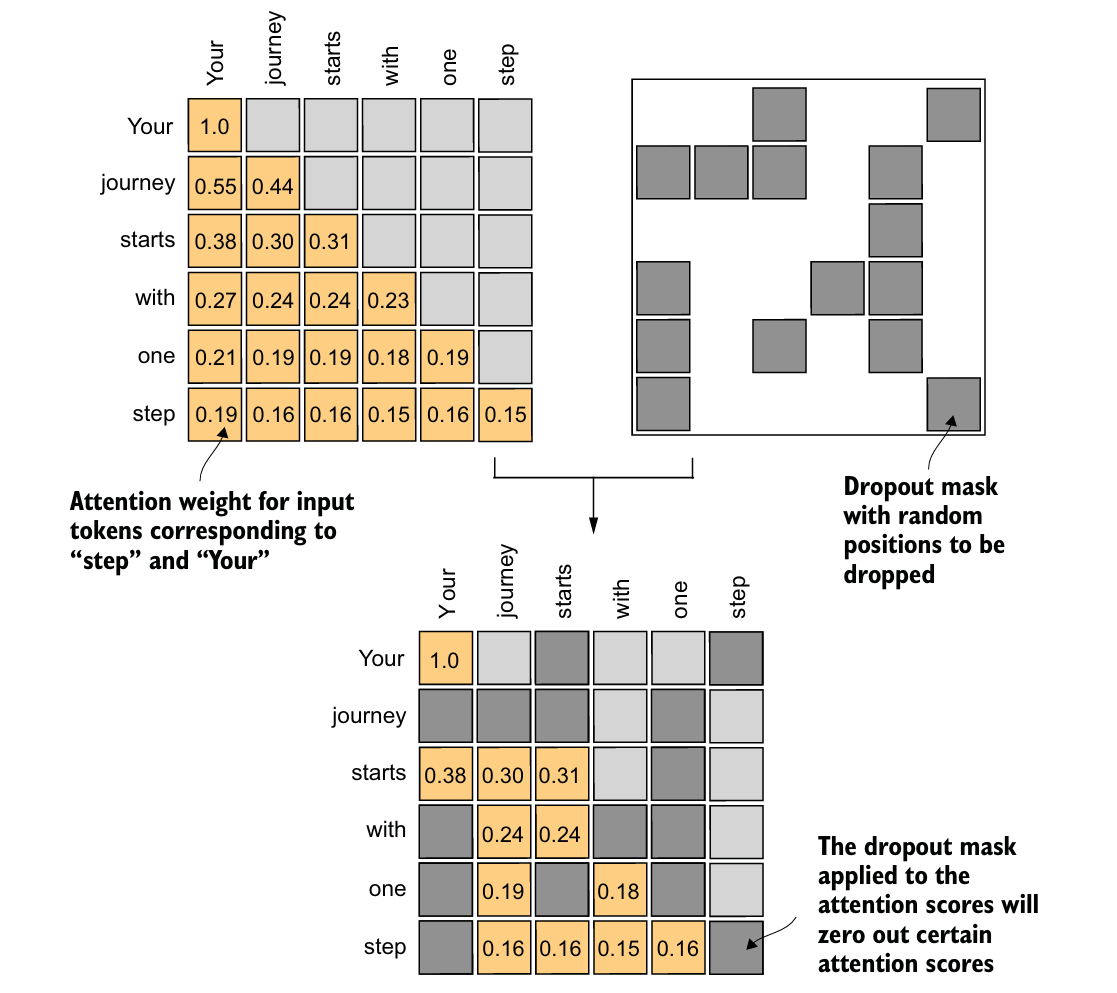" width = 50% >

Dropout can be applied in several places:

for example, after computing the attention weights;

or after multiplying the attention weights with the value vectors.


Here, we will apply the dropout mask after computing the attention weights because it's more common.

In [ ]:
dropout = torch.nn.Dropout(0.5) # dropout rate of 50% means it will mask out 50% of the pos
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example)) # see how it is masking with zeros in random positions in every run

tensor([[2., 2., 0., 0., 2., 2.],
        [0., 0., 2., 0., 0., 2.],
        [0., 0., 2., 2., 0., 0.],
        [2., 2., 0., 2., 2., 2.],
        [0., 2., 2., 0., 0., 0.],
        [2., 2., 0., 0., 0., 0.]])


In [ ]:
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3986, 0.6014, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2526, 0.3791, 0.3683, 0.0000, 0.0000, 0.0000],
        [0.2265, 0.2839, 0.2794, 0.2103, 0.0000, 0.0000],
        [0.1952, 0.2363, 0.2331, 0.1820, 0.1534, 0.0000],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])

In [ ]:
torch.manual_seed(23)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7971, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5052, 0.7582, 0.7366, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5587, 0.4206, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4662, 0.0000, 0.3068, 0.0000],
        [0.3115, 0.4183, 0.4097, 0.2839, 0.0000, 0.0000]])


To compensate for the reduction in
 active elements, the values of the remaining elements in the matrix are scaled up.

 Mathematically:

```
Let p = dropout rate
Remaining fraction = 1 - p
To keep the expected value the same, we divide by (1 - p)
```

 This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains
 consistent during both the training and inference phases.


##Implementing a compact causal self-attention class

We are going to make sure that we can handle batches consisting of more than one input.

In [ ]:
# To simulate a batch, we are going to stack inputs over inputs.

batch = torch.stack((inputs,inputs), dim = 0)
batch, batch.shape

(tensor([[[0.4300, 0.1500, 0.8900],
          [0.5500, 0.8700, 0.6600],
          [0.5700, 0.8500, 0.6400],
          [0.2200, 0.5800, 0.3300],
          [0.7700, 0.2500, 0.1000],
          [0.0500, 0.8000, 0.5500]],
 
         [[0.4300, 0.1500, 0.8900],
          [0.5500, 0.8700, 0.6600],
          [0.5700, 0.8500, 0.6400],
          [0.2200, 0.5800, 0.3300],
          [0.7700, 0.2500, 0.1000],
          [0.0500, 0.8000, 0.5500]]]),
 torch.Size([2, 6, 3]))

In [ ]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors
        # in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
        # do not exceed `context_length` before reaching this forward method.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


##4. Extending single-head attention to multi-head attention

The term “multi-head” refers to dividing the attention mechanism into multiple
 “heads,” each operating independently. In this context, a single causal attention mod
ule can be considered single-head attention, where there is only one set of attention
 weights processing the input sequentially.

This is going to be a simple implementation of Multi-Head Attention mechanism.

Each head is a CausalAttention module.
When you pass an input through it, each head runs separately.
Then the outputs of all heads are joined (concatenated) into one final output/

In [ ]:
import torch.nn as nn

class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, bias=False):
    super().__init__()
    self.heads = nn.ModuleList(
                 [CausalAttention(d_in, d_out, context_length,
                 dropout, qkv_bias=bias) for _ in range(num_heads)]
                              )
    # Here, each head is going to be a Causal Attention module.
    # So you create a list of that many CausalAttention objects.
    # nn.ModuleList tells PyTorch that these are modules with learnable parameters.
    # We have smth like :
    # self.heads = [ head1, head2 ]
    # Each head are independent and have their own weights.

  def forward(self, x):
      return torch.cat([head(x) for head in self.heads], dim=-1) # dim = -1 bc we want to concatenate the embedding_dim ,try doing 0 or 1
      # and see the difference to understand further

torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape [batch_size, no_of_tokens, embedding_dim ]", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape [batch_size, no_of_tokens, embedding_dim ] torch.Size([2, 6, 4])


In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4.



```
      ┌───────────────┐            ┌───────────────┐
      │   CausalAttention Head 1   │
      └───────────────┘            │
             │                     │
       Output: [-0.4519, 0.2216]   │
                                   │
                                   │  CONCATENTATE (dim = -1)
                                   ├────────────→  [-0.4519, 0.2216, 0.4772, 0.1063]
                                   │
      ┌───────────────┐            │
      │   CausalAttention Head 2   │
      └───────────────┘            └───────────────┘
             │
       Output: [0.4772, 0.1063]

```



In [ ]:
# head_dim = dimension of the context vector before we concatenate them
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`,
        # this will result in errors in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
        # do not exceed `context_length` before reaching this forward method.

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


## How the data is actually moving here :



```
batch = 1, tokens = 2, d_out = 4, num_heads = 2 → head_dim = 2
```

Our input after linear layers and .view() looks like this:
```
keys = [[
    # token 0
    [ [1,2],  # head 0
      [3,4] ],# head 1

    # token 1
    [ [5,6],  # head 0
      [7,8] ] # head 1
]]
```

Right now, we have this arranged according to tokens. So when we do :

```
keys = keys.transpose(1, 2)
```
We get :



```
Old shape: (1, 2, 2, 2) → (batch, tokens, heads, head_dim)
New shape: (1, 2, 2, 2) → (batch, heads, tokens, head_dim)
```

Now, it's reordered according to head. Each head now has its own matrix of tokens.

```
keys[0, 0] = [ [1,2],  # head 0 sees token0
               [5,6] ] # head 0 sees token1

keys[0, 1] = [ [3,4],  # head 1 sees token0
               [7,8] ] # head 1 sees token1

```



Then

```
attn_scores = queries @ keys.transpose(2, 3)
```
```
queries (head0):
token0: [1, 2]
token1: [5, 6]

keys (head0):
token0: [1, 2]
token1: [5, 6]

```

Shape for both: (tokens=2, head_dim=2)

keys.transpose(2,3) flips last 2 dims (head_dim × tokens):

```
queries (head0):
token0: [1, 2]
token1: [5, 6]

keys (head0):
token0: [1, 2]
token1: [5, 6]

```

Shape for both: (tokens=2, head_dim=2)

keys.transpose(2,3) flips last 2 dims (head_dim × tokens):
```
keys.T (head0) =
[ [1, 5],  # first row = key_dim 0
  [2, 6] ] # second row = key_dim 1
```
This is now shape (head_dim, tokens) → ready for matrix multiplication with queries.

Finally,


```
attn_scores (head0) = [
  [5, 17],   # token0 attends token0, token1
  [17, 61]   # token1 attends token0, token1
]
```




